## Introducción

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- La calidad de la predicción
- La velocidad de la predicción
- El tiempo requerido para el entrenamiento

## Preparación de datos

### Inicialización

In [79]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import math
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.metrics import classification_report

from lightgbm import LGBMRegressor 

### Importación de datos

In [80]:
df = pd.read_csv("https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv")

### Vista rápida

In [81]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [82]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [83]:
duplicates = df.duplicated().sum()
print("")
print('La base de datos contiene {} filas duplicadas.'.format(duplicates))
print('_______________________________________________')


La base de datos contiene 262 filas duplicadas.
_______________________________________________


De manera rápida podemos observar que la base de datos tiene algunos detalles. Por ejemplo, los títulos de las columnas no están en formato snake. También podemos ver que la base de datos tiene valores ausentes, además, el tipo de datos de las columnas no es del tipo float y para finalizar la base de datos tiene filas duplicadas.

In [84]:
# Bucle en los encabezados poniendo todo en minúsculas
new_col_names = []

for i in df.columns:
    new_name = i.lower()
    new_col_names.append(new_name)

df.columns = new_col_names    
print(df.columns)

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'mileage', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')


In [85]:
# Cambiar el nombre de los encabezados
df = df.rename(columns={'datecrawled':'date_crawled','vehicletype':'vehicle_type',
                        'registrationyear':'registration_year','registrationmonth':'registration_month',
                        'fueltype':'fuel_type','notrepaired':'not_repaired','datecreated':'date_created',
                        'numberofpictures':'number_of_pictures','postalcode':'postal_code', 
                        'lastseen':'last_seen'})

display(df.head())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [86]:
# Limpieza de datos de valores NA
df = df.dropna()
# Eliminación de duplicados
df = df.drop_duplicates()

display(df.head(5))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47


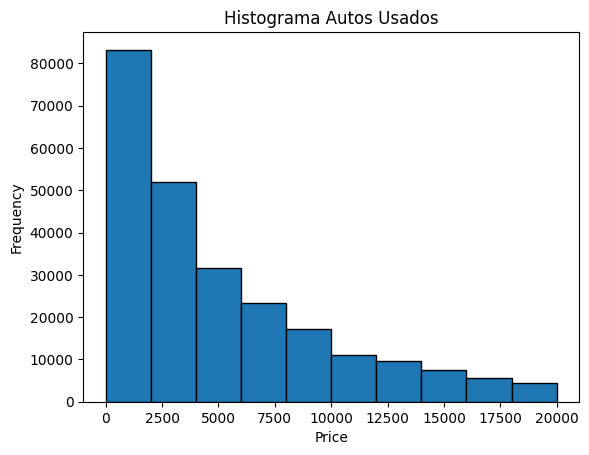

In [87]:
# Histograma de precios
df["price"].plot(kind='hist',ylabel='Frequency',xlabel='Price',
                 title='Histograma Autos Usados',edgecolor="black")
plt.show()

Al parecer existe un número significativo de carros cuyo valor es igual a 0. Por el momento, se van a dejar estos datos como están. Sin embargo, es algo que llama la atención y que probablemente sea un error.

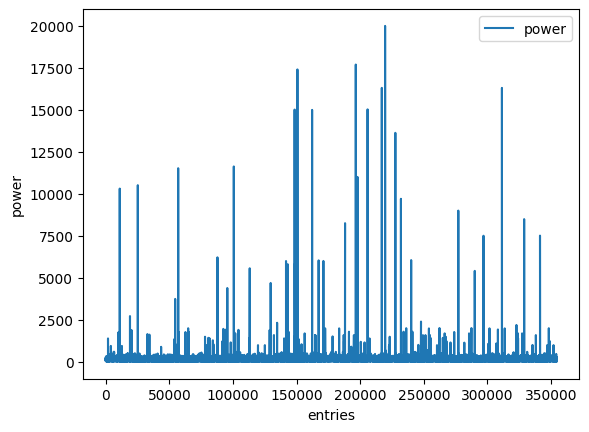

In [88]:
# Gráfica de potencia
df[df["power"]>0].plot(y='power',ylabel='power',xlabel='entries')
plt.show()

En la gráfica de potencia podemos observar que ciertos valores son muy altos, los cuales no son reales y sería mejor eliminarlos. También existen valores iguales a 0, lo cual resulta incongruente y sería mejor eliminarlos también. Los automóviles superdeportivos tienen alrededor de 1000 CV, por lo cual ese será el criterio: valores menores a 1000.

In [89]:
df = df[df["power"]<1000]
df = df[df["power"]!=0]
display(df.head())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47


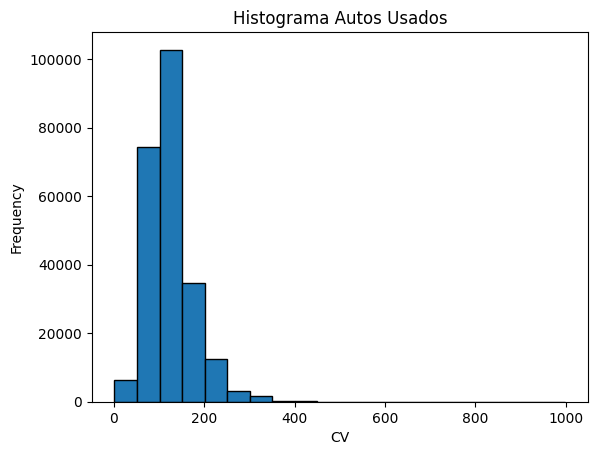

In [90]:
# Histograma de potencia
df["power"].plot(kind='hist',ylabel='Frequency',xlabel='CV',
                 title='Histograma Autos Usados',edgecolor="black",bins=20)
plt.show()

La base de datos se encuentra en un estado en el cual se puede empezar a utilizar para construir modelos de machine learning. Sin embargo, no todas las columnas van a ser significativas para predecir el precio. Por lo tanto, se van a seleccionar solo las que influyen en el precio.

In [91]:
df_filtered = df[["price","vehicle_type","registration_year","gearbox","power","model","mileage","fuel_type","brand","not_repaired"]]
df_filtered_ohe = df[["price","vehicle_type","registration_year","gearbox","power","mileage","fuel_type","brand","not_repaired"]]
df_filtered.reset_index(drop=True, inplace=True )
df_filtered.head(5)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
1,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
2,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
3,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
4,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no


Las regresiones lineales trabajan solamente con valores numéricos, pero esta base de datos tiene características categóricas que influyen en el precio de los carros, como la marca, el tipo de vehículo, el tipo de transmisión, entre otros. Es por eso que las características categóricas se tienen que convertir en numéricas, por medio de OrdinalEncoder.

In [92]:
df_filtered_cat = df_filtered[['vehicle_type','gearbox','model','fuel_type','brand','not_repaired']]
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(df_filtered_cat), columns=df_filtered_cat.columns)

df_filtered.iloc[:,1] = data_ordinal.iloc[:,0]
df_filtered.iloc[:,3] = data_ordinal.iloc[:,1]
df_filtered.iloc[:,5] = data_ordinal.iloc[:,2]

df_filtered.iloc[:,7] = data_ordinal.iloc[:,3]
df_filtered.iloc[:,8] = data_ordinal.iloc[:,4]
df_filtered.iloc[:,9] = data_ordinal.iloc[:,5]

display(df_filtered.head())
display(df_filtered.info())

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,1500,5.0,2001,1.0,75,116.0,150000,6.0,37.0,0.0
1,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
2,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,1.0
3,2200,1.0,2004,1.0,109,8.0,150000,6.0,25.0,0.0
4,0,4.0,1980,1.0,50,166.0,40000,6.0,37.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235827 entries, 0 to 235826
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              235827 non-null  int64 
 1   vehicle_type       235827 non-null  object
 2   registration_year  235827 non-null  int64 
 3   gearbox            235827 non-null  object
 4   power              235827 non-null  int64 
 5   model              235827 non-null  object
 6   mileage            235827 non-null  int64 
 7   fuel_type          235827 non-null  object
 8   brand              235827 non-null  object
 9   not_repaired       235827 non-null  object
dtypes: int64(4), object(6)
memory usage: 18.0+ MB


None

In [93]:
df_filtered = df_filtered.copy()

df_filtered["vehicle_type"] = df_filtered["vehicle_type"].astype(int)
df_filtered["gearbox"] = df_filtered["gearbox"].astype(int)
df_filtered["fuel_type"] = df_filtered["fuel_type"].astype(int)
df_filtered["brand"] = df_filtered["brand"].astype(int)
df_filtered["not_repaired"] = df_filtered["not_repaired"].astype(int)
df_filtered["model"] = df_filtered["model"].astype(int)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235827 entries, 0 to 235826
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   price              235827 non-null  int64
 1   vehicle_type       235827 non-null  int64
 2   registration_year  235827 non-null  int64
 3   gearbox            235827 non-null  int64
 4   power              235827 non-null  int64
 5   model              235827 non-null  int64
 6   mileage            235827 non-null  int64
 7   fuel_type          235827 non-null  int64
 8   brand              235827 non-null  int64
 9   not_repaired       235827 non-null  int64
dtypes: int64(10)
memory usage: 18.0 MB


En este punto, los datos se encuentran limpios y filtrados. Además, los datos categóricos relevantes ya se convirtieron en numéricos, lo cual nos permitirá realizar predicciones de precio.

## Entrenamiento del modelo 

En esta parte del análisis, vamos a separar la base de datos limpia en tres conjuntos: Un conjunto de entrenamiento, uno de validación y uno de prueba. Para esto, utilizamos la función 'train_test_split'. El porcentaje de la segmentación es el siguiente:

* Conjunto de entrenamiento = 60%
* Conjunto de validación = 20%
* Conjunto de prueba = 20%

In [94]:
# Datos para primer modelo de regresión lineal, bosque aleatorio y LGBM.

df_train, df_val_test = train_test_split(df_filtered, test_size=0.4, random_state=0)
df_valid, df_test = train_test_split(df_val_test, test_size=0.5, random_state=0)

target_train = df_train['price']
features_train = df_train.drop(['price'],axis=1)

target_valid = df_valid['price']
features_valid = df_valid.drop(['price'],axis=1)

target_test = df_test['price']
features_test = df_test.drop(['price'],axis=1)

# Datos para modelo regresión lineal para OHE

data_ohe = pd.get_dummies(df_filtered_ohe, drop_first=True)

df_train_ohe, df_val_test_ohe = train_test_split(data_ohe, test_size=0.4, random_state=0)
df_valid_ohe, df_test_ohe = train_test_split(df_val_test_ohe, test_size=0.5, random_state=0)

target_train_ohe = df_train_ohe['price']
features_train_ohe = df_train_ohe.drop(['price'],axis=1)

target_test_ohe = df_test_ohe['price']
features_test_ohe = df_test_ohe.drop(['price'],axis=1)

### Modelo de regresión lineal

El modelo de regresión lineal se utilizará como baseline o prueba de cordura. No se espera que tenga gran precisión, pero se espera que los otros modelos se comporten significativamente mejor. Además, el modelo de regresión lineal no tiene hiperparámetros que ajustar, así que se probará directamente con el conjunto de prueba.

In [95]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)

# RECM
print("Raíz del error cuadrático medio (RECM): %.4f" % root_mean_squared_error(target_test, predictions))
# R2
print("Coeficiente de determinación: %.2f" % r2_score(target_test, predictions))

Raíz del error cuadrático medio (RECM): 2924.4992
Coeficiente de determinación: 0.62


In [96]:
observations = np.arange(start=1, stop=np.size(predictions)+1, step=1)
residuals = predictions - target_test

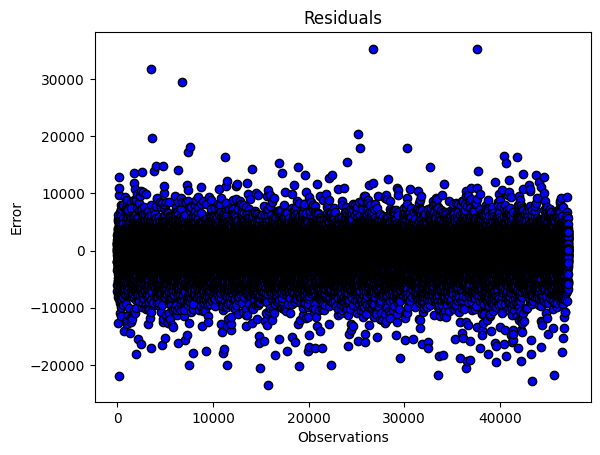

Promedio residuales : -14.0920
Desviación estandard  2924.4652


In [97]:
# Plot outputs
plt.scatter(observations, residuals, color="blue",edgecolor="black")
plt.xlabel("Observations")
plt.ylabel("Error")
plt.title("Residuals")
plt.show()

print("Promedio residuales : %.4f" % np.average(residuals))
print("Desviación estandard  %.4f" % np.std(residuals))

### Modelo de regresión lineal (OHE)

El segundo modelo de regresión lineal difiere del primer modelo en los datos. Este modelo contiene una característica menos ('model') y, además, utiliza la técnica de codificación one-hot para representar los datos categóricos de manera numérica. 

In [98]:
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)
predictions = model.predict(features_test_ohe)

# RECM
print("Raíz del error cuadrático medio (RECM): %.4f" % root_mean_squared_error(target_test_ohe, predictions))
# R2
print("Coeficiente de determinación: %.2f" % r2_score(target_test_ohe, predictions))

Raíz del error cuadrático medio (RECM): 2733.9404
Coeficiente de determinación: 0.67


Podemos observar que el RECM de este modelo es ligeramente menor que el RECM del primer modelo, pero esta diferencia es muy pequeña. Además, para su ejecución fue necesario quitar la columna 'model' de nuestros datos. Esta columna es importante, ya que en la práctica sabemos que el modelo de un vehículo es una variable que afecta el precio de venta.

### Bosque aleatorio

In [99]:
# Default settings
model_1 = RandomForestRegressor(random_state=12345)
model_1.fit(features_train, target_train)
predictions = model_1.predict(features_test)

# RECM
print("Raíz del error cuadrático medio (RECM): %.4f" % root_mean_squared_error(target_test, predictions))
# R2
print("Coeficiente de determinación: %.2f" % r2_score(target_test, predictions))

Raíz del error cuadrático medio (RECM): 1656.6092
Coeficiente de determinación: 0.88


In [100]:
# Ajustando n_estimators
recm_forest = np.zeros((2, 15))

for i in range (1,16):
    est = i*10
    model_2 = RandomForestRegressor(random_state=123, n_estimators=est)
    model_2.fit(features_train, target_train)
    print("Computing RandomForestRegressor with n_estimators =",est)
    predictions_forest = model_2.predict(features_valid)
    recm_forest[0,i-1] = est
    recm_forest[1,i-1] = root_mean_squared_error(target_valid, predictions_forest)

best_n_estimators = (recm_forest[1,:].argmin()+1)    
print("El mejor n_estimators =", best_n_estimators*10, ", RECM=", recm_forest[1,best_n_estimators-1], end='')

Computing RandomForestRegressor with n_estimators = 10
Computing RandomForestRegressor with n_estimators = 20
Computing RandomForestRegressor with n_estimators = 30
Computing RandomForestRegressor with n_estimators = 40
Computing RandomForestRegressor with n_estimators = 50
Computing RandomForestRegressor with n_estimators = 60
Computing RandomForestRegressor with n_estimators = 70
Computing RandomForestRegressor with n_estimators = 80
Computing RandomForestRegressor with n_estimators = 90
Computing RandomForestRegressor with n_estimators = 100
Computing RandomForestRegressor with n_estimators = 110
Computing RandomForestRegressor with n_estimators = 120
Computing RandomForestRegressor with n_estimators = 130
Computing RandomForestRegressor with n_estimators = 140
Computing RandomForestRegressor with n_estimators = 150
El mejor n_estimators = 150 , RECM= 1666.480240223272

### Light Gradient-Boosting Machine (LGBM)

In [101]:
from lightgbm import LGBMRegressor 

In [102]:
model_3 = LGBMRegressor(metric='rmse',verbose=0) 
model_3.fit(features_train,target_train) 
predictions = model_3.predict(features_test)

# RECM
print("Raíz del error cuadrático medio (RECM): %.4f" % root_mean_squared_error(target_test, predictions))
# R2
print("Coeficiente de determinación: %.2f" % r2_score(target_test, predictions))

Raíz del error cuadrático medio (RECM): 1730.3865
Coeficiente de determinación: 0.87


In [103]:
# Ajustando n_estimators
recm_lgbmregressor = np.zeros((2, 100))

for i in range (1,101):
    est = i*10
    model_4 = LGBMRegressor(random_state=123, n_estimators=est,verbose=0)
    model_4.fit(features_train, target_train)
    if est%100 == 0:
        print("Computing LGBMRegressor with n_estimators =",est)
    predictions_lgbmr = model_4.predict(features_train)
    recm_lgbmregressor[0,i-1] = est
    recm_lgbmregressor[1,i-1] = root_mean_squared_error(target_train, predictions_lgbmr)

best_n_estimators = (recm_lgbmregressor[1,:].argmin()+1)    
print("El mejor n_estimators =", best_n_estimators*10, ", RECM=", recm_lgbmregressor[1,best_n_estimators-1], end='')    

Computing LGBMRegressor with n_estimators = 100
Computing LGBMRegressor with n_estimators = 200
Computing LGBMRegressor with n_estimators = 300
Computing LGBMRegressor with n_estimators = 400
Computing LGBMRegressor with n_estimators = 500
Computing LGBMRegressor with n_estimators = 600
Computing LGBMRegressor with n_estimators = 700
Computing LGBMRegressor with n_estimators = 800
Computing LGBMRegressor with n_estimators = 900
Computing LGBMRegressor with n_estimators = 1000
El mejor n_estimators = 1000 , RECM= 1414.3435444145118

## Análisis del modelo

### Bosque aleatorio

El hiperparámetro que se ajustó para incrementar la precisión del bosque aleatorio fue "n_estimators". De manera general, se puede decir que el ajuste de este parámetro por encima de 100 hace el entrenamiento del modelo considerablemente lento. Por eso, se optó por incrementar este valor hasta llegar a 150.

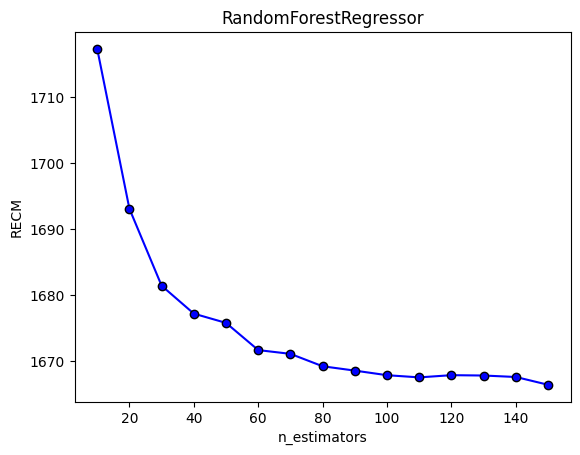

Raíz del error cuadrático medio (RECM): 1653.5801
Coeficiente de determinación: 0.88


In [104]:
plt.plot(recm_forest[0,:],recm_forest[1,:],"bo-",markeredgecolor='k')
plt.xlabel("n_estimators")
plt.ylabel("RECM")
plt.title("RandomForestRegressor")
plt.show()

predictions_forest = model_2.predict(features_test)
# RECM
print("Raíz del error cuadrático medio (RECM): %.4f" % root_mean_squared_error(target_test, predictions_forest))
# R2
print("Coeficiente de determinación: %.2f" % r2_score(target_test, predictions_forest))

### Light Gradient-Boosting Machine 

El hiperparámetro que se ajustó para incrementar la precisión del Light Gradient-Boosting Machine (LGBM) fue "n_estimators". De manera general, se puede decir que ajustar este parámetro es relativamente más rápido que en el bosque aleatorio. Se pudo incrementar hasta 1000 sin tener gran penalización en términos computacionales.

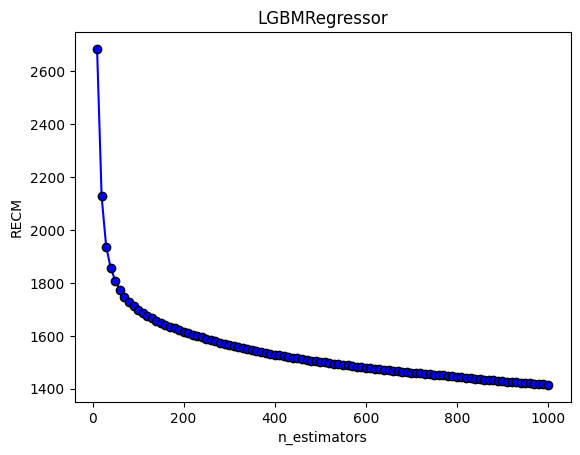

Raíz del error cuadrático medio (RECM): 1595.8608
Coeficiente de determinación: 0.89


In [105]:
plt.plot(recm_lgbmregressor[0,:],recm_lgbmregressor[1,:],"bo-",markeredgecolor='k')
plt.xlabel("n_estimators")
plt.ylabel("RECM")
plt.title("LGBMRegressor")
plt.show()

predictions_lgbmr = model_4.predict(features_test)
# RECM
print("Raíz del error cuadrático medio (RECM): %.4f" % root_mean_squared_error(target_test, predictions_lgbmr))
# R2
print("Coeficiente de determinación: %.2f" % r2_score(target_test, predictions_lgbmr))

## Conclusiones

En este proyecto se crearon tres modelos para predecir el precio de autos usados a partir de una base de datos. El modelo de regresión lineal se creó simplemente para usarlo como referencia, sabiendo que los siguientes dos modelos deben ser significativamente mejores que el primero. El parámetro de referencia es la Raíz del Error Cuadrático Medio (RECM) y este valor es mucho menor para los modelos de Bosque Aleatorio y LGBM que para el de regresión lineal (valores para el conjunto de prueba).

* RECM
    * Regresión lineal: 2924.4992
    * Bosque Aleatorio: 1653.5801 
    * LGBM: 1595.8608
    
El modelo que mejor se desempeñó fue el LGBM, ya que permitió un mayor ajuste del "n_estimators" sin tener una penalización significativa en el tiempo de cómputo. Sin embargo, para valores pequeños de "n_estimators", el Bosque Aleatorio se comportó mejor, ya que para los mismos ajustes tiene un menor valor de RECM, tal como se puede observar en la gráfica de abajo.

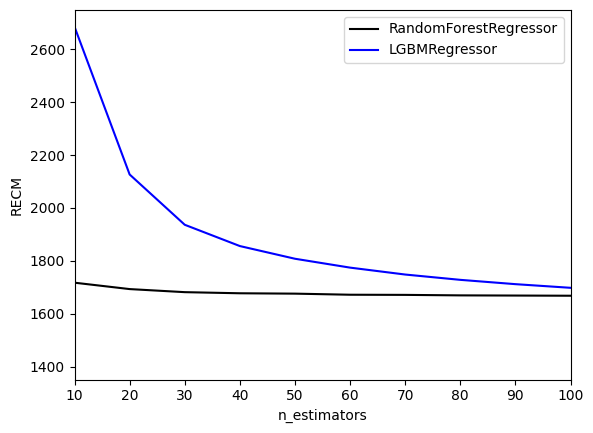

In [106]:
plt.plot(recm_forest[0,:],recm_forest[1,:],"k-")
plt.plot(recm_lgbmregressor[0,:],recm_lgbmregressor[1,:],"b-")
plt.xlim(10,100)
plt.legend(["RandomForestRegressor","LGBMRegressor"])
plt.xlabel("n_estimators")
plt.ylabel("RECM")
plt.show()